In [1]:
import math

from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = \
    pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", 
                sep=",")

# california_housing_dataframe = california_housing_dataframe.reindex(
#     np.random.permutation(california_housing_dataframe.index))

/Users/sanchez/Projects/py/Anaconda/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
california_housing_dataframe.head(2)
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


In [3]:
def preprocess_features(california_housing_dataframe):
    """Prepares input features from California housing data set.

    Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
    Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
    """
    
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]
    ]
    
    processed_features = selected_features.copy()
    
    # Create a synthetic feature.
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    
    return processed_features

In [4]:
def preprocess_targets(california_housing_dataframe):
    """Prepares target features (i.e., labels) from California housing data set.

    Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
    Returns:
    A DataFrame that contains the target feature.
    """
    
    output_targets = pd.DataFrame()
    
    # Scale the target to be in units of thousands of dollars.
    output_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0)
    
    return output_targets

## Inspect data

In [5]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

training_features = preprocess_features(california_housing_dataframe.head(12000))
print ("Training features")
training_features.describe()

training_targets = preprocess_targets(california_housing_dataframe.head(12000))
print ("Training targets")
training_targets.describe()

validation_features = preprocess_features(california_housing_dataframe.tail(5000))
print ("Validation features")
validation_features.describe()

validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
print ("Validation targets")
validation_targets.describe()

Training features


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.5,28.7,2631.0,538.1,1423.4,499.6,3.9,2.0
std,2.1,2.0,12.6,2114.6,412.7,1121.0,375.0,1.9,1.1
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1455.0,295.0,786.0,280.0,2.6,1.5
50%,34.2,-118.5,29.0,2129.0,436.0,1168.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3153.0,651.0,1717.0,607.0,4.8,2.3
max,42.0,-114.6,52.0,30405.0,4957.0,35682.0,4769.0,15.0,52.0


Training targets


,median_house_value
count,12000.0
mean,207.4
std,115.5
min,15.0
25%,120.2
50%,180.8
75%,264.2
max,500.0


Validation features


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.4,2674.1,542.5,1444.5,505.0,3.9,2.0
std,2.2,2.0,12.5,2329.2,442.0,1209.8,406.6,2.0,1.3
min,32.6,-124.2,2.0,11.0,3.0,3.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1471.0,300.8,801.0,285.0,2.6,1.5
50%,34.3,-118.5,29.0,2125.0,429.0,1165.0,405.0,3.5,2.0
75%,37.7,-118.0,37.0,3145.8,644.0,1731.2,601.0,4.8,2.3
max,41.9,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,55.2


Validation targets


,median_house_value
count,5000.0
mean,207.0
std,117.2
min,15.0
25%,118.2
50%,178.9
75%,266.8
max,500.0


## Plot latitude/longitude vs median house value

Text(0.5,1,'Validation Data')

(32, 43)

(-126, -112)

Text(0.5,1,'Training Data')

(32, 43)

(-126, -112)

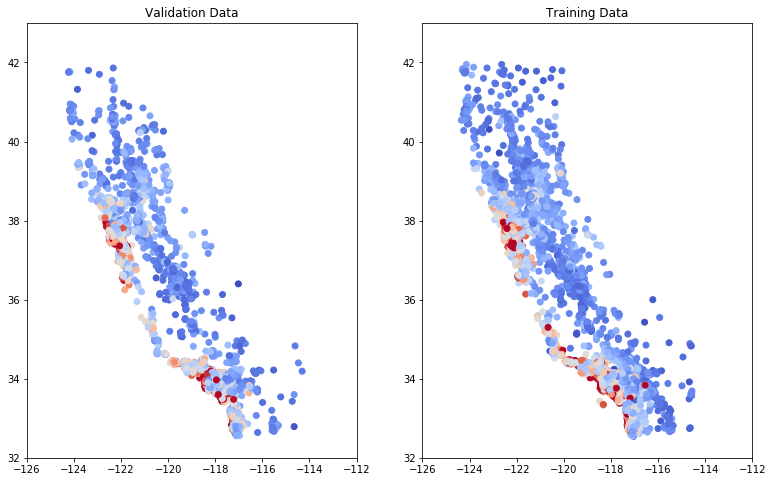

In [6]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])

plt.scatter(validation_features["longitude"],
            validation_features["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1, 2, 2)
ax.set_title("Training Data")


ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])

plt.scatter(training_features["longitude"],
            training_features["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())

# Red is expensive

In [7]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [8]:
def construct_feature_columns(input_features):
    """
    Construct the TensorFlow Feature Columns.
    
    Ars:
        input_features: The names of the numerical input features to use.
        
    Returns:
        A set of feature columns
    """
    
    return set([tf.feature_column.numeric_column(my_feature)
               for my_feature in input_features])

### NOTE: It's okay to reference the code from the previous exercises, but make sure to call predict() on the appropriate data sets.

Compare the losses on training data and validation data. With a single raw feature, our best root mean squared error (RMSE) was of about 180.


In [13]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_features,
    training_targets,
    validation_features,
    validation_targets
    ):
    """Trains a linear regression model of multiple features.
    
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time
    
    Args:
        learning_reate: a `float`, the learning rate
        steps: A non-zero `int`, the total number of training steps. A training step
            consists of a forward and backward pass using a simple batch.
        batch_size: A non-zero `int`, the batch size.
        training_features: A `DataFrame` containing one or more columns from 
            `california_housing_dataframe` to use as input features for training
        training_targets: same.
        validation_features: same.
        validation_targets: same.
        
    Returns:
        A `LinearRegressor` object trained on the training data.
    """
    
    periods = 10
    steps_per_period = steps / periods
    
    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns = construct_feature_columns(training_features),
        optimizer=my_optimizer
    )
    
    # 1. Create input functions.
    training_input_fn =  lambda:my_input_fn(
        training_features, 
        training_targets["median_house_value"], 
        batch_size=batch_size)
    
    predict_training_input_fn = lambda:my_input_fn(
        training_features, 
        training_targets["median_house_value"], 
        num_epochs=1, 
        shuffle=False)
    
    predict_validation_input_fn = lambda:my_input_fn(
        validation_features, 
        validation_targets["median_house_value"], 
        num_epochs=1, 
        shuffle=False)
    
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics
    
    print ("Training model...")
    print ("RMSE (on training data): ")
    training_rmse = []
    validation_rmse = []
    
    for period in range(0, periods):
        # Train the model, starting from the prior state
        linear_regressor.train(
            input_fn = training_input_fn,
            steps = steps_per_period
        )
        
        # 2. Take a break and compute predictions.
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions =  linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
            
        # Compute training and validation loss
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets)
        )
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets)
        )
        
        # Occasionally print the current loss
        print (" period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
    print ("Model training finished")
    
    # Output a graph of loss metrics over periods
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root mean squared error vs periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor


Training model...
RMSE (on training data): 
 period 00 : 236.06
 period 01 : 234.68
 period 02 : 233.34
 period 03 : 231.99
 period 04 : 230.72
 period 05 : 229.39
 period 06 : 228.05
 period 07 : 226.73
 period 08 : 225.43
 period 09 : 224.13
Model training finished


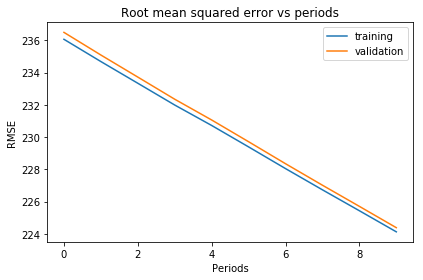

In [14]:
linear_regressor = train_model(
    learning_rate = 0.00001,
    steps = 100,
    batch_size = 1,
    training_features = training_features,
    training_targets = training_targets,
    validation_features = validation_features,
    validation_targets = validation_targets
    )

Training model...
RMSE (on training data): 
 period 00 : 181.21
 period 01 : 165.12
 period 02 : 166.50
 period 03 : 165.28
 period 04 : 164.72
 period 05 : 165.56
 period 06 : 165.11
 period 07 : 165.35
 period 08 : 165.83
 period 09 : 164.95
Model training finished


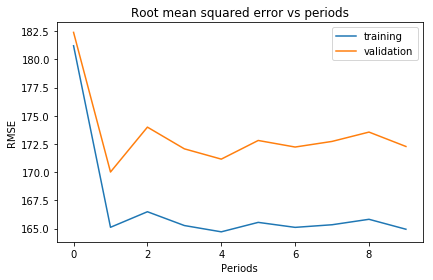

In [16]:
linear_regressor = train_model(
    learning_rate = 0.0001,
    steps = 500,
    batch_size = 20,
    training_features = training_features,
    training_targets = training_targets,
    validation_features = validation_features,
    validation_targets = validation_targets
    )

Training model...
RMSE (on training data): 
 period 00 : 209.99
 period 01 : 188.62
 period 02 : 174.30
 period 03 : 166.82
 period 04 : 164.96
 period 05 : 165.34
 period 06 : 167.06
 period 07 : 168.79
 period 08 : 169.52
 period 09 : 169.05
Model training finished


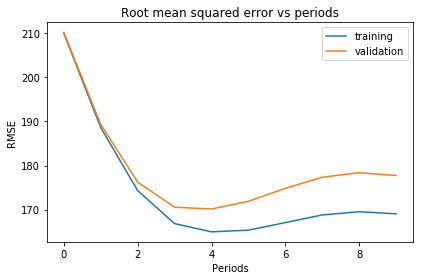

In [21]:
linear_regressor = train_model(
    learning_rate = 0.00003,
    steps = 700,
    batch_size = 5,
    training_features = training_features,
    training_targets = training_targets,
    validation_features = validation_features,
    validation_targets = validation_targets
    )

In [20]:
california_housing_test_data = pd.read_csv(
    "https://storage.googleapis.com/mledu-datasets/california_housing_test.csv", sep=",")

In [22]:
test_features = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda:my_input_fn(
        test_features, 
        test_targets["median_house_value"], 
        num_epochs=1, 
        shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

test_root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets)
)

print (test_root_mean_squared_error)


164.69067882309628
